2024-10-19 22:37:17.023 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.758 
  command:

    streamlit run C:\Users\sss\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-10-19 22:37:17.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-19 22:37:17.765 Session state does not fu

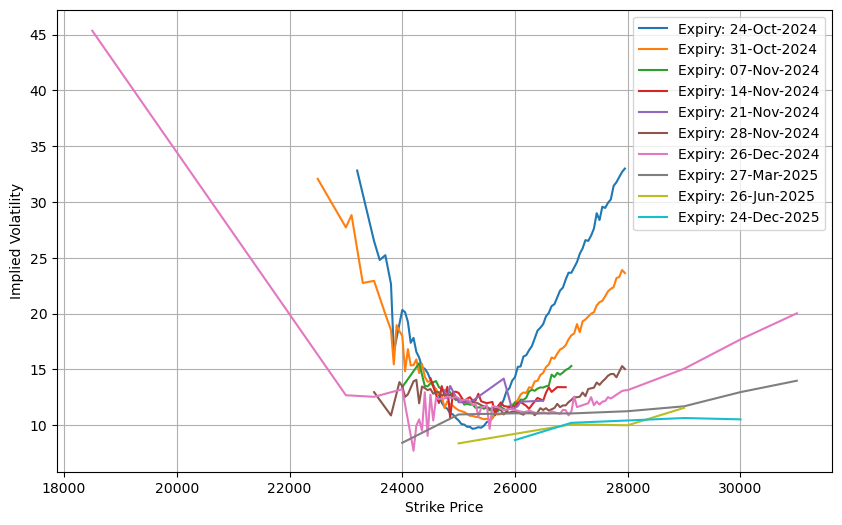

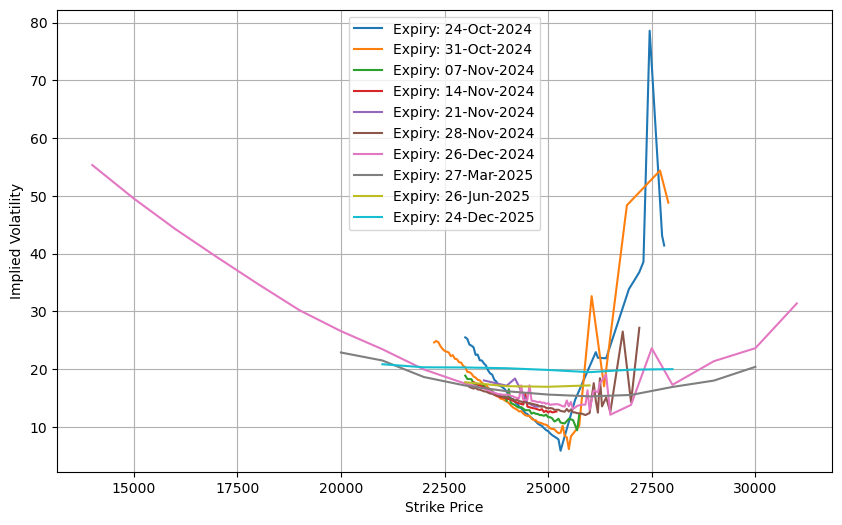

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from datetime import datetime
import streamlit as st  # Importing streamlit for dashboard

# Function to fetch options data
def fetch_options_data(stock_symbol):
    session = requests.Session()
    url = f'https://www.nseindia.com/api/option-chain-indices?symbol={stock_symbol}'
    
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.nseindia.com/',
        'X-Requested-With': 'XMLHttpRequest',
    }

    response = session.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if 'records' in data and 'data' in data['records']:
            calls_data, puts_data = [], []
            for option in data['records']['data']:
                strike_price = option['strikePrice']
                expiry_date = option['expiryDate']
                if 'CE' in option:
                    calls_data.append({'strikePrice': strike_price, 'expiryDate': expiry_date, **option['CE']})
                if 'PE' in option:
                    puts_data.append({'strikePrice': strike_price, 'expiryDate': expiry_date, **option['PE']})
            calls_df = pd.DataFrame(calls_data) if calls_data else pd.DataFrame()
            puts_df = pd.DataFrame(puts_data) if puts_data else pd.DataFrame()
            return calls_df, puts_df
    return None, None

# Load baseline skew from CSV if it exists
def load_baseline_skew(filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    return None

# Save baseline skew to CSV
def save_baseline_skew(baseline_skew, filename):
    baseline_skew.to_csv(filename, index=False)

# Calculate implied volatility skew, filtering out zero IVs
def calculate_volatility_skew(options_df):
    return options_df[options_df['impliedVolatility'] > 0][['strikePrice', 'expiryDate', 'impliedVolatility']]

# Plot volatility skew using Streamlit's plotting features
def plot_volatility_skew(df, option_type):
    st.subheader(f'Volatility Skew for {option_type}')
    fig, ax = plt.subplots(figsize=(10, 6))
    sorted_expiry_dates = sorted(df['expiryDate'].unique(), key=pd.to_datetime)
    for expiry in sorted_expiry_dates:
        subset = df[df['expiryDate'] == expiry]
        ax.plot(subset['strikePrice'], subset['impliedVolatility'], label=f'Expiry: {expiry}')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Implied Volatility')
    ax.legend()
    ax.grid()
    st.pyplot(fig)

# Compare current and baseline skews
def compare_skews(baseline_skew, current_skew, threshold):
    significant_changes = []
    baseline_dict = {(row['strikePrice'], row['expiryDate']): row['impliedVolatility'] for _, row in baseline_skew.iterrows()}
    current_dict = {(row['strikePrice'], row['expiryDate']): row['impliedVolatility'] for _, row in current_skew.iterrows()}
    
    for key, current_iv in current_dict.items():
        baseline_iv = baseline_dict.get(key)
        if baseline_iv is not None and abs(current_iv - baseline_iv) > threshold:
            significant_changes.append((key[0], key[1], current_iv, baseline_iv))
    return significant_changes

# Display significant changes
def display_significant_changes(changes, option_type):
    if changes:
        changes_df = pd.DataFrame(changes, columns=['Strike Price', 'Expiry', 'Current IV', 'Baseline IV'])
        st.subheader(f'Significant {option_type} Changes')
        st.table(changes_df)
    else:
        st.write(f"No significant changes for {option_type}.")

# Save significant changes to a CSV file
def save_significant_changes_to_file(significant_changes, option_type):
    date_str = datetime.now().strftime('%Y-%m-%d')
    filename = f'significant_changes_{option_type}_{date_str}.csv'
    changes_df = pd.DataFrame(significant_changes, columns=['Strike', 'Expiry', 'Current IV', 'Baseline IV'])
    changes_df.to_csv(filename, index=False)
    st.write(f"Significant changes saved to {filename}")

# Streamlit dashboard logic
def main():
    st.title('Options Volatility Skew Dashboard')
    
    # Sidebar for stock symbol and threshold input
    stock_symbol = st.sidebar.text_input("Stock Symbol", value="NIFTY")
    threshold = st.sidebar.slider("Significant Change Threshold (in %)", 1, 10, 5) / 100
    baseline_calls_filename = "baseline_calls_skew.csv"
    baseline_puts_filename = "baseline_puts_skew.csv"

    # Load baseline skews
    baseline_calls = load_baseline_skew(baseline_calls_filename)
    baseline_puts = load_baseline_skew(baseline_puts_filename)
    
    # Tabs for different functionalities
    tab1, tab2 = st.tabs(["Volatility Skew", "Significant Changes"])

    # Tab for fetching and plotting volatility skew
    with tab1:
        st.write(f"Fetching options data for {stock_symbol}...")
        calls, puts = fetch_options_data(stock_symbol)

        if calls is not None and puts is not None:
            calls_data = calculate_volatility_skew(calls)
            puts_data = calculate_volatility_skew(puts)

            # Plot skews
            plot_volatility_skew(calls_data, 'Calls')
            plot_volatility_skew(puts_data, 'Puts')

            # Compare skews and display significant changes
            if baseline_calls is not None and baseline_puts is not None:
                st.subheader("Comparing Skews")
                significant_call_changes = compare_skews(baseline_calls, calls_data, threshold)
                significant_put_changes = compare_skews(baseline_puts, puts_data, threshold)

                # Save significant changes to files
                if significant_call_changes:
                    save_significant_changes_to_file(significant_call_changes, 'Calls')
                if significant_put_changes:
                    save_significant_changes_to_file(significant_put_changes, 'Puts')

            # Save the current skews as the new baseline
            save_baseline_skew(calls_data, baseline_calls_filename)
            save_baseline_skew(puts_data, baseline_puts_filename)
        else:
            st.write("No data available for the given stock symbol.")

    # Tab for displaying significant changes
    with tab2:
        st.subheader("Significant Changes Alerts")
        if baseline_calls is not None and baseline_puts is not None:
            significant_call_changes = compare_skews(baseline_calls, calls_data, threshold)
            significant_put_changes = compare_skews(baseline_puts, puts_data, threshold)
            display_significant_changes(significant_call_changes, 'Calls')
            display_significant_changes(significant_put_changes, 'Puts')
        else:
            st.write("No baseline data available.")

if __name__ == "__main__":
    main()
